<a href="https://colab.research.google.com/github/JeanQeue/Data-Viz---CO2_Emission/blob/main/NoWaste_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales forecasting
## No Waste Allocation Tool
### What will be our sales forecast in next 3 months, by product, by boutique ?

------------------------------

## Drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Package import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)

!ls drive/MyDrive/'No Waste'/'Sales forecasting'

'Outlet H00 FRA sellout data.csv'


## Data import

In [ ]:
"""
Old version with Drive and kaggle dataset https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data

df_items_cat = pd.read_csv('drive/MyDrive/No Waste/Sales forecasting/item_categories.csv')
df_items = pd.read_csv('drive/MyDrive/No Waste/Sales forecasting/items.csv')
df_shops = pd.read_csv('drive/MyDrive/No Waste/Sales forecasting/shops.csv')
df_sales = pd.read_csv('drive/MyDrive/No Waste/Sales forecasting/sales_train.csv')
df_test = pd.read_csv('drive/MyDrive/No Waste/Sales forecasting/test.csv')
df_sample_submission = pd.read_csv('drive/MyDrive/No Waste/Sales forecasting/sample_submission.csv')

merged_df = df_sales.merge(df_shops, on='shop_id', how='left')\
                    .merge(df_items, on='item_id', how='left')\
                    .merge(df_items_cat, on='item_category_id', how='left')
"""

#New version with selloutdata from outlet H00 in France
#df_first_import = pd.read_csv("/content/Outlet H00 FRA sellout data.csv")
df_first_import = pd.read_csv("/content/drive/MyDrive/No Waste/Sales forecasting/Outlet H00 FRA sellout data.csv")

## Data Manipulation

In [ ]:
df_first_import.head()

,store_code,store_name,day,sap_code,barcode,source_code,group_reference,item_type,mars_article_id,label,material_status,local_name,division,group_signature,signature,franchise,brand,subbrand,axis,subaxis,class,subclass,sales_incl,total_items
0,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043900,3.600524e+12,3600523827756,P230084R,MAR,3600523827756 X,CR LipLiner Cout Nu 107 Seine Sunse,002,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1
1,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043901,3.600524e+12,AA043900,P230084R,MAR,AA043900 X,RAL CR LIP LINER 107 SEINE SUNS.NU,001,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1
2,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043901,3.600524e+12,AA043901,P230084R,MAR,AA043901 X,CR LIPLINER COUT NU 107 SEINE SUNSE,002,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1
3,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043901,3.600524e+12,AA043901,P230084R,MAR,AA043901 X,CR LIPLINER COUT NU 107 SEINE SUNSE,005,CR LipLiner Cout Nu 107 c est diman,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1
4,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043902,3.600524e+12,3600523827756,P230084R,MAR,3600523827756 X,CR LIPLINER COUT NU 107 SEINE SUNSE,UNI,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1


### Feature engineering

In [ ]:
def create_date_features(sale_df, date_col='day', sale_col='total_items'):
  """
  Engineers relevant date features for sales forecasting.

  Args:
      sale_df (pd.DataFrame): DataFrame containing sales data with a date column.
      date_col (str, optional): Name of the date column. Defaults to 'date'.

  Returns:
      pd.DataFrame: Original DataFrame with added date features.
  """

  # Ensure date column is datetime type
  sale_df[date_col] = pd.to_datetime(sale_df[date_col], format = '%Y-%m-%d')

  # Basic time features
  sale_df['year'] = sale_df[date_col].dt.year
  sale_df['month'] = sale_df[date_col].dt.month
  sale_df['day_of_month'] = sale_df[date_col].dt.day
  sale_df['day_of_week'] = sale_df[date_col].dt.dayofweek  # Monday=0, Sunday=6
  sale_df['quarter'] = sale_df[date_col].dt.quarter
  sale_df['week_of_year'] = sale_df[date_col].dt.isocalendar().week
  sale_df['day_of_year'] = sale_df[date_col].dt.dayofyear

  # Cyclical encoding for seasonality
  sale_df['month_sin'] = np.sin(2 * np.pi * sale_df['month'] / 12)
  sale_df['month_cos'] = np.cos(2 * np.pi * sale_df['month'] / 12)
  sale_df['day_of_week_sin'] = np.sin(2 * np.pi * sale_df['day_of_week'] / 7)
  sale_df['day_of_week_cos'] = np.cos(2 * np.pi * sale_df['day_of_week'] / 7)

  # Lag features (example: sales from previous week/month)
  sale_df['lag_7'] = sale_df[sale_col].shift(7).fillna(method='bfill')  # Fill NaNs with the next valid value
  sale_df['lag_30'] = sale_df[sale_col].shift(30).fillna(method='bfill')

  # Rolling window features (example: moving average)
  sale_df['rolling_mean_7'] = (
      sale_df[sale_col].rolling(window=7, min_periods=1).mean().fillna(method='bfill')
  )
  sale_df['rolling_mean_30'] = (
      sale_df[sale_col].rolling(window=30, min_periods=1).mean().fillna(method='bfill')
  )

  # Time since last event (e.g., holiday) - requires additional data and logic based on your business context

  return sale_df


In [ ]:
df = create_date_features(df_first_import, date_col="day", sale_col="total_items")

<ipython-input-35-2d2d1a39b0c4>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sale_df['lag_7'] = sale_df[sale_col].shift(7).fillna(method='bfill')  # Fill NaNs with the next valid value
<ipython-input-35-2d2d1a39b0c4>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sale_df['lag_30'] = sale_df[sale_col].shift(30).fillna(method='bfill')
<ipython-input-35-2d2d1a39b0c4>:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sale_df[sale_col].rolling(window=7, min_periods=1).mean().fillna(method='bfill')
<ipython-input-35-2d2d1a39b0c4>:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sale_df[sale_col].rolling(window=30, min_periods=1).mean

### EDA

In [ ]:
df.head()

,store_code,store_name,day,sap_code,barcode,source_code,group_reference,item_type,mars_article_id,label,material_status,local_name,division,group_signature,signature,franchise,brand,subbrand,axis,subaxis,class,subclass,sales_incl,total_items,year,month,day_of_month,day_of_week,quarter,week_of_year,day_of_year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,lag_7,lag_30,rolling_mean_7,rolling_mean_30
0,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043900,3.600524e+12,3600523827756,P230084R,MAR,3600523827756 X,CR LipLiner Cout Nu 107 Seine Sunse,002,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1,2024,6,19,2,2,25,171,1.224647e-16,-1.0,0.974928,-0.222521,1.0,1.0,1.0,1.0
1,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043901,3.600524e+12,AA043900,P230084R,MAR,AA043900 X,RAL CR LIP LINER 107 SEINE SUNS.NU,001,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1,2024,6,19,2,2,25,171,1.224647e-16,-1.0,0.974928,-0.222521,1.0,1.0,1.0,1.0
2,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043901,3.600524e+12,AA043901,P230084R,MAR,AA043901 X,CR LIPLINER COUT NU 107 SEINE SUNSE,002,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1,2024,6,19,2,2,25,171,1.224647e-16,-1.0,0.974928,-0.222521,1.0,1.0,1.0,1.0
3,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043901,3.600524e+12,AA043901,P230084R,MAR,AA043901 X,CR LIPLINER COUT NU 107 SEINE SUNSE,005,CR LipLiner Cout Nu 107 c est diman,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1,2024,6,19,2,2,25,171,1.224647e-16,-1.0,0.974928,-0.222521,1.0,1.0,1.0,1.0
4,H00,H00 OUTLET THE VILLAGE,2024-06-19,AA043902,3.600524e+12,3600523827756,P230084R,MAR,3600523827756 X,CR LIPLINER COUT NU 107 SEINE SUNSE,UNI,NaN,CPD,CPD Excluding CCB,L'Oreal Paris,L'Oreal Make-Up,L'Oreal Cosmetics,L'Oreal Color Riche,MakeUp,Lip Makeup,Lip Liner,Lip Liners,5.7,1,2024,6,19,2,2,25,171,1.224647e-16,-1.0,0.974928,-0.222521,1.0,1.0,1.0,1.0


#### Global EDA on sales_df

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851013 entries, 0 to 851012
Data columns (total 39 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   store_code       851013 non-null  object        
 1   store_name       851013 non-null  object        
 2   day              851013 non-null  datetime64[ns]
 3   sap_code         847649 non-null  object        
 4   barcode          847648 non-null  float64       
 5   source_code      851013 non-null  object        
 6   group_reference  847649 non-null  object        
 7   item_type        851013 non-null  object        
 8   mars_article_id  851013 non-null  object        
 9   label            851013 non-null  object        
 10  material_status  851013 non-null  object        
 11  local_name       287239 non-null  object        
 12  division         847649 non-null  object        
 13  group_signature  847649 non-null  object        
 14  si

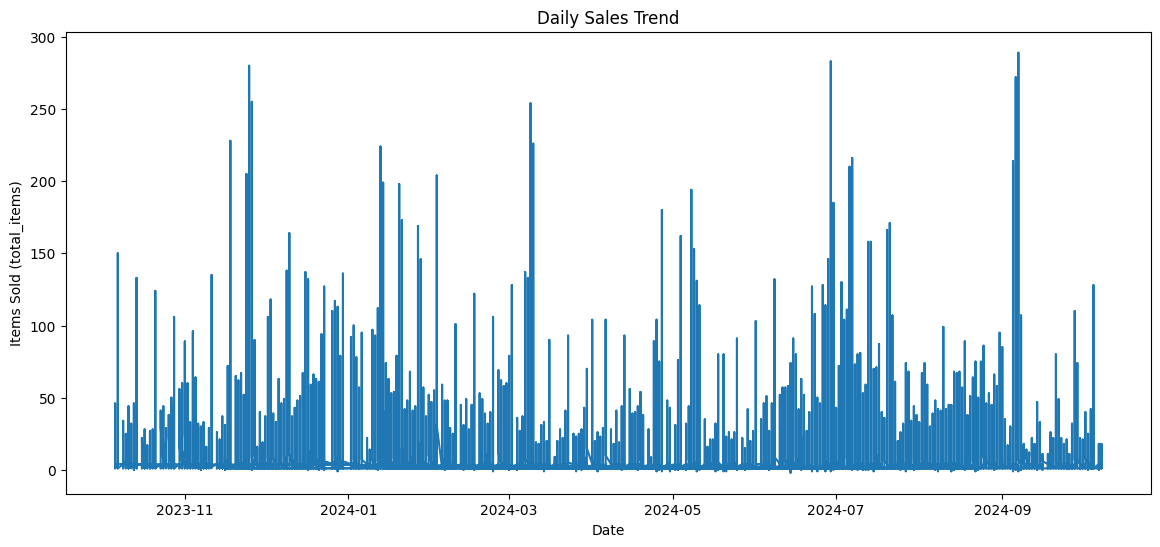

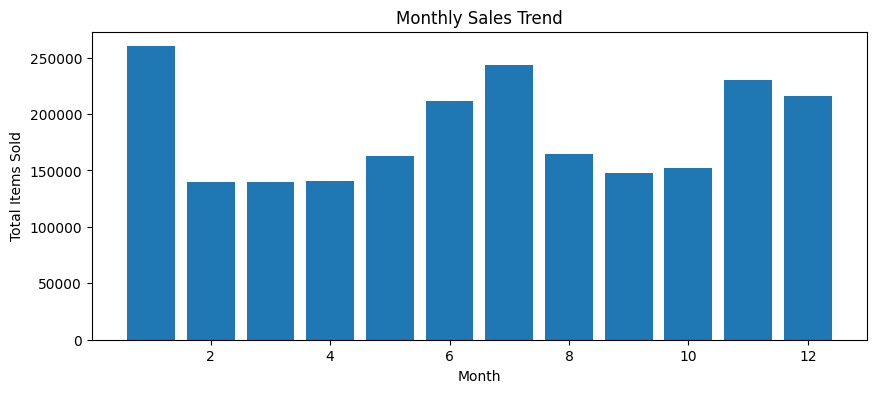

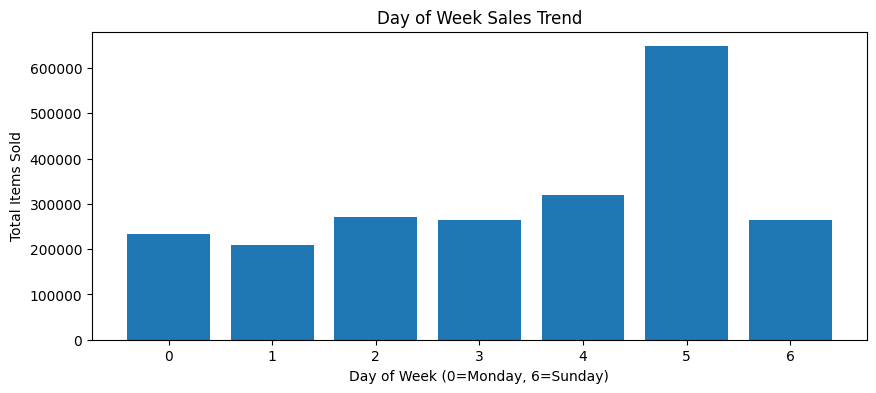

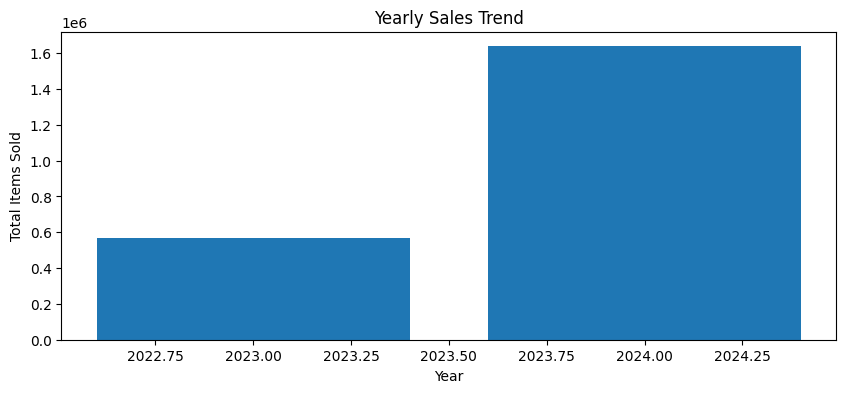

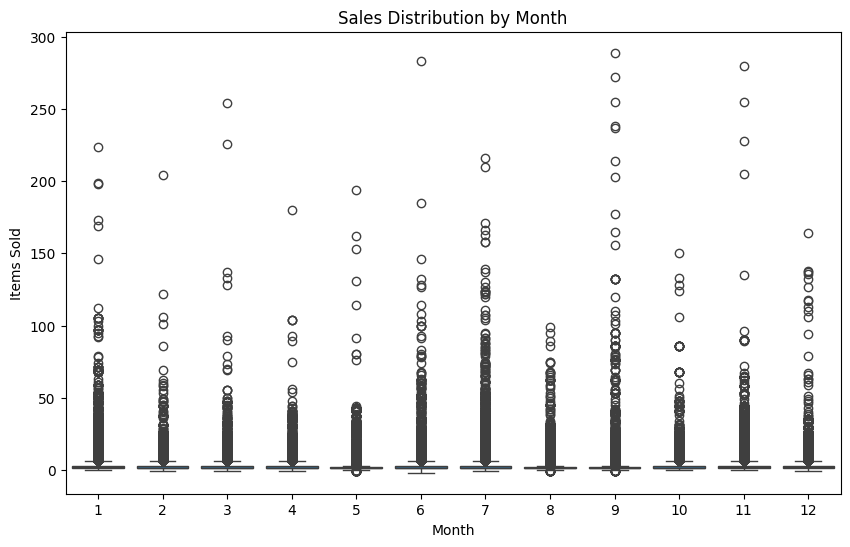

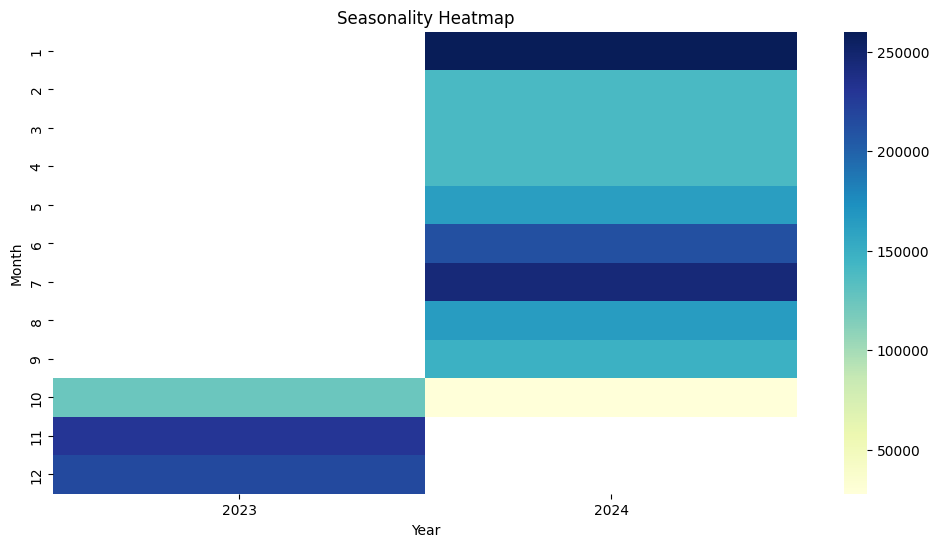

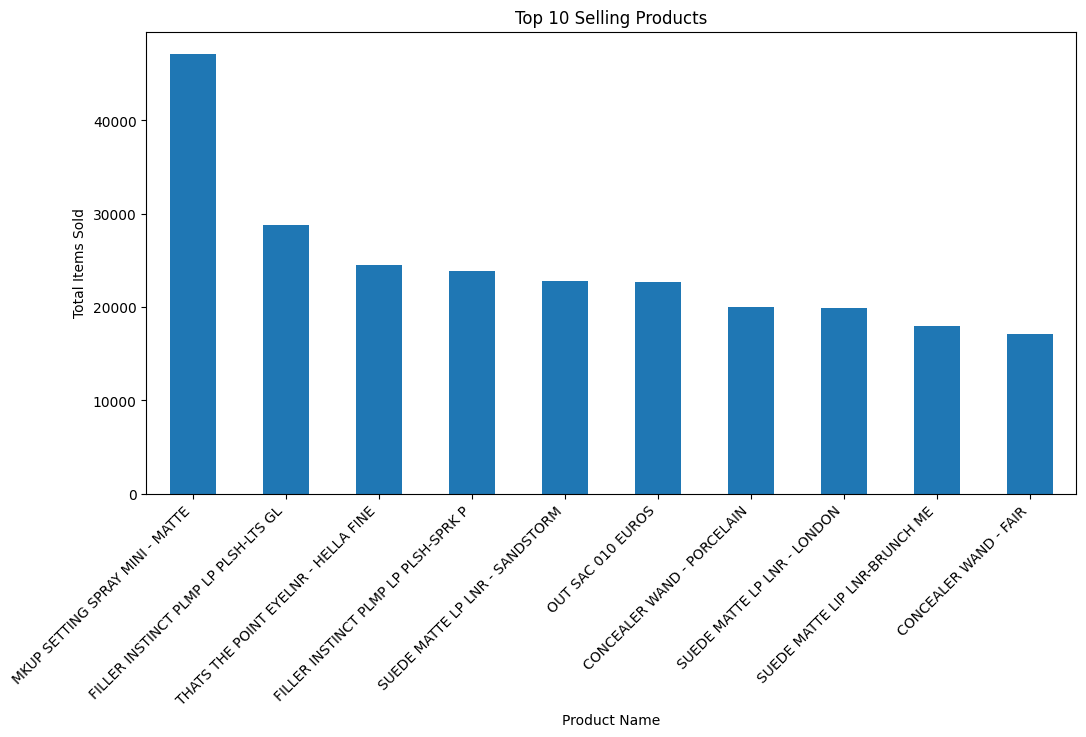

<ipython-input-38-a95949177b8c>:92: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='subaxis', y=sales_col, data=df_sales, estimator=sum, ci=None)


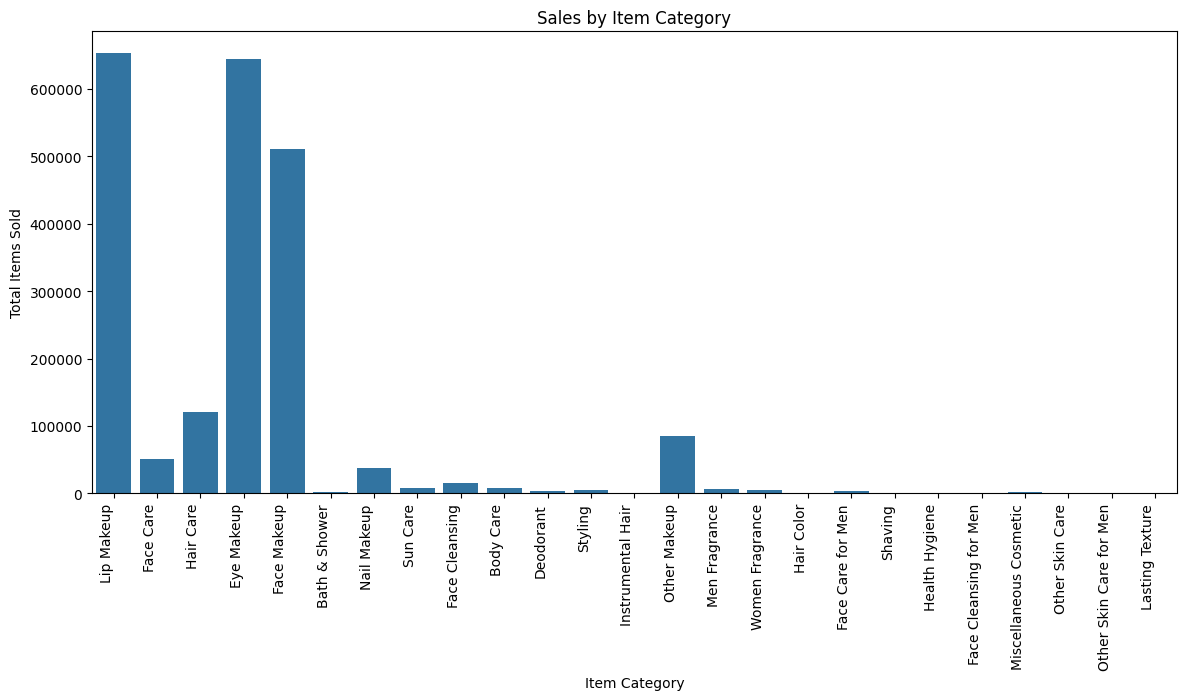

In [ ]:
def eda_sales(df_sales, date_col = 'day', sales_col = "total_items"):
    """
    Performs Exploratory Data Analysis (EDA) on sales data.

    Args:
        df_sales (pd.DataFrame): DataFrame containing sales data with date features.
    """

    # 1. Basic Statistics and Information
    print("Data Information:")
    print(df_sales.info())
    print("Descriptive Statistics:")
    print(df_sales[[sales_col, 'year', 'month']].describe())

    # 2. Time Series Visualization
    plt.figure(figsize=(14, 6))
    plt.title("Daily Sales Trend")
    plt.plot(df_sales[date_col], df_sales[sales_col])
    plt.xlabel("Date")
    plt.ylabel("Items Sold (total_items)")
    plt.show()

    # 3. Monthly Sales Trend
    monthly_sales = df_sales.groupby('month')[sales_col].sum()
    plt.figure(figsize=(10, 4))
    plt.title("Monthly Sales Trend")
    plt.bar(monthly_sales.index, monthly_sales.values)
    plt.xlabel("Month")
    plt.ylabel("Total Items Sold")
    plt.show()

    # 4. Day of Week Sales Trend
    weekday_sales = df_sales.groupby('day_of_week')[sales_col].sum()
    plt.figure(figsize=(10, 4))
    plt.title("Day of Week Sales Trend")
    plt.bar(weekday_sales.index, weekday_sales.values)
    plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
    plt.ylabel("Total Items Sold")
    plt.show()

    # 5. Yearly Sales Trend
    yearly_sales = df_sales.groupby('year')[sales_col].sum()
    plt.figure(figsize=(10, 4))
    plt.title("Yearly Sales Trend")
    plt.bar(yearly_sales.index, yearly_sales.values)
    plt.xlabel("Year")
    plt.ylabel("Total Items Sold")
    plt.show()

    # 6. Boxplot for Outlier Analysis
    plt.figure(figsize=(10, 6))
    plt.title("Sales Distribution by Month")
    sns.boxplot(x='month', y=sales_col, data=df_sales)
    plt.xlabel("Month")
    plt.ylabel("Items Sold")
    plt.show()

    # 7. Heatmap for Seasonality (if multiple years of data)
    if len(df_sales['year'].unique()) > 1:
        monthly_sales_pivot = df_sales.pivot_table(index='month', columns='year', values=sales_col, aggfunc='sum')
        plt.figure(figsize=(12, 6))
        plt.title("Seasonality Heatmap")
        sns.heatmap(monthly_sales_pivot, cmap="YlGnBu")
        plt.xlabel("Year")
        plt.ylabel("Month")
        plt.show()

    # 8. Top Selling Products
    top_products = df_sales.groupby('label')[sales_col].sum().nlargest(10)
    plt.figure(figsize=(12, 6))
    plt.title("Top 10 Selling Products")
    top_products.plot(kind='bar')
    plt.xlabel("Product Name")
    plt.ylabel("Total Items Sold")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    """# 9. Sales by Shop (Top 5 Shops)
    top_shops = df_sales.groupby('store_name')[sales_col].sum().nlargest(5).index
    plt.figure(figsize=(12, 6))
    plt.title("Sales by Shop (Top 5)")
    sns.barplot(x='store_name', y=sales_col, data=df_sales[df_sales['store_name'].isin(top_shops)],
                order=top_shops, estimator=sum, ci=None)
    plt.xlabel("Shop Name")
    plt.ylabel("Total Items Sold")
    plt.xticks(rotation=45, ha='right')
    plt.show()"""

    # 10. Sales by Item Category
    plt.figure(figsize=(14, 6))
    plt.title("Sales by Item Category")
    sns.barplot(x='subaxis', y=sales_col, data=df_sales, estimator=sum, ci=None)
    plt.xlabel("Item Category")
    plt.ylabel("Total Items Sold")
    plt.xticks(rotation=90, ha='right')
    plt.show()

# Call the EDA function
eda_sales(df)


### Data Cleaning

In [ ]:
# Check for missing values in all columns
print(df.isnull().sum())

store_code              0
store_name              0
day                     0
sap_code             3364
barcode              3365
source_code             0
group_reference      3364
item_type               0
mars_article_id         0
label                   0
material_status         0
local_name         563774
division             3364
group_signature      3364
signature            3364
franchise            4104
brand                4104
subbrand             4721
axis                14717
subaxis             14732
class               14775
subclass            19398
sales_incl              0
total_items             0
year                    0
month                   0
day_of_month            0
day_of_week             0
quarter                 0
week_of_year            0
day_of_year             0
month_sin               0
month_cos               0
day_of_week_sin         0
day_of_week_cos         0
lag_7                   0
lag_30                  0
rolling_mean_7          0
rolling_mean

**Fill in missing values**

In [ ]:
def fill_missing_by_group(df, col_to_fill, group_cols, method='median'):
    """Fills missing values in a column based on groups."""
    df[col_to_fill] = df.groupby(group_cols)[col_to_fill].transform(lambda x: x.fillna(getattr(x, method)()))
    return df


# Fill missing 'total_items' by product and month
df = fill_missing_by_group(df, 'total_items', ['label', 'month'])

# Fill missing 'lag_7' and 'lag_30' with forward fill (use next valid value if available)
df['lag_7'] = df['lag_7'].fillna(method='ffill')
df['lag_30'] = df['lag_30'].fillna(method='ffill')

# Fill missing rolling means with 0 (or consider another strategy)
df['rolling_mean_7'] = df['rolling_mean_7'].fillna(0)
df['rolling_mean_30'] = df['rolling_mean_30'].fillna(0)

<ipython-input-40-2d90edc8b2ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lag_7'] = df['lag_7'].fillna(method='ffill')
<ipython-input-40-2d90edc8b2ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lag_30'] = df['lag_30'].fillna(method='ffill')


#### Outliers detection and handling

In [ ]:
def cap_outliers(df, col, upper_percentile=0.99, lower_percentile=0.01):
    """Caps outliers at specified percentiles."""
    upper_limit = df[col].quantile(upper_percentile)
    lower_limit = df[col].quantile(lower_percentile)
    df[col] = np.clip(df[col], lower_limit, upper_limit)
    return df

df = cap_outliers(df, 'total_items') # Cap at 99th percentile

# 4. One-Hot Encoding
df = pd.get_dummies(df, columns=['label', 'store_name', 'subaxis'], drop_first=True)

# 5. Feature Scaling (Standardization)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()  # Selects all numerical features
numerical_features.remove('total_items')  # Avoid scaling target
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])



print(df.info())
df.head()

## Model definition

### Baseline model

In [ ]:

     df['total_items_log'] = np.log1p(df['total_items'])  # Use log1p to handle potential zeros


In [ ]:
   train_size = int(len(df) * 0.8)  # Use 80% for training
   X_train, X_val = df[numerical_features][:train_size], df[numerical_features][train_size:]
   y_train, y_val = df['total_items_log'][:train_size], df['total_items_log'][train_size:] # Use log-transformed target



**Linear Regression**

In [ ]:
   model = LinearRegression()
   model.fit(X_train, y_train)
   y_pred = model.predict(X_val)

### More advanced model


## Performance comparison

## Final thoughts